# Taming text

In [133]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from wordcloud import WordCloud
from PIL import Image

import nltk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Word cloud from the corpus

In this first part we want to extract from Mrs Clinton emails a word cloud. 

### 1.1) Data extraction

In [134]:
path = 'hillary-clinton-emails/'
emails = pd.read_csv(path + "Emails.csv")
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


First, we verify if we can we use the Id as an index.

In [135]:
emails["Id"].duplicated().value_counts()

False    7945
Name: Id, dtype: int64

It seems that we are provided with either the raw text file or an "attempt at extracting the body" of the message. We compare them on one instance to understand them better.

In [136]:
print(emails.head()["RawText"][1])

UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739546
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Attachments:
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
CONFIDENTIAL
March 3, 2011
For: Hillary
From: Sid
Re: Syria aiding Qaddafi
This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note
to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly complex crisis. It
seems that the situation is developing into a protracted civil war with various nations backing opposing sides
with unforeseen consequences. Under these circumstances the crucial challenge is to deprive Qaddafi of his
strategic depth—his support bo

In [137]:
print(emails.head()["ExtractedBodyText"][1])

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary


I hate rapid conclusion but it feels as if the Extracted Body Text feature won't get us far. We thus create a new data frame to process.

In [138]:
emails_rawtext = emails["RawText"]
emails_rawtext.head()

0    UNCLASSIFIED\nU.S. Department of State\nCase N...
1    UNCLASSIFIED\nU.S. Department of State\nCase N...
2    UNCLASSIFIED\nU.S. Department of State\nCase N...
3    UNCLASSIFIED\nU.S. Department of State\nCase N...
4    B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
Name: RawText, dtype: object

We finally extract the corpus

In [139]:
corpus = emails_rawtext.str.cat(sep=" ")
with open("corpus.txt", "w") as text_file:
    print(corpus, file=text_file)

### 1.2) Initial wordcloud

In [140]:
text = corpus
mask = np.array(Image.open("trumpmask.jpg"))
wordcloud = WordCloud(background_color="white", mask=mask).generate(text)


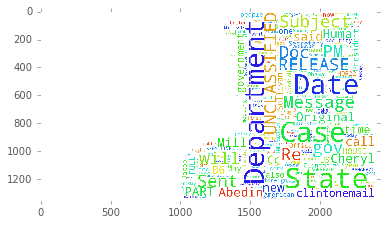

In [141]:
plt.imshow(wordcloud)

### 1.3) Data processing

First we can explore the data a bit. The words Department and Date seem to appear quite frequently. But how frequent ?

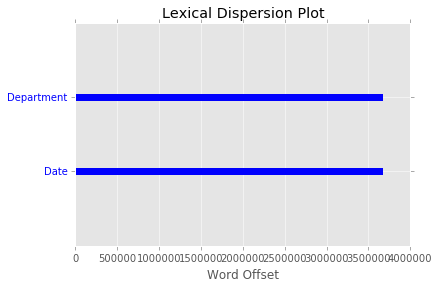

In [145]:
f=open('corpus.txt')    
raw = f.read()                     
tokens = nltk.word_tokenize(raw)   
text = nltk.Text(tokens)      

text.dispersion_plot(["Department", "Date"])

They are words that appear in each email and they are not very relevant. 

In [149]:
words = [w.lower() for w in tokens]
words[0:5]


['unclassified', 'u.s.', 'department', 'of', 'state']

In [151]:
vocab = sorted(set(words))
vocab

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "''en",
 "''expeditionary",
 "''ft",
 "''responsible",
 "''rn",
 "''s",
 "'*",
 "',7x.7.„",
 "'-l",
 "'..ask",
 "'..hai7-pfrsou",
 "'.1ilotylc",
 "'.36",
 "'.filotylc",
 "'.he",
 "'.iyar",
 "'.or",
 "'01",
 "'014-20439",
 "'05",
 "'08",
 "'09",
 "'1",
 "'1'",
 "'1-idr22",
 "'1.344",
 "'1.com",
 "'10",
 "'10t",
 "'11",
 "'11114es",
 "'1111•111•111b",
 "'114—j",
 "'11\\tc",
 "'16",
 "'1davis",
 "'1he",
 "'1i",
 "'1•",
 "'2",
 "'2009",
 "'212",
 "'3",
 "'3-",
 "'30s",
 "'314",
 "'32.22952'729",
 "'320election",
 "'4",
 "'4..",
 "'404-527-4020",
 "'41k",
 "'4444444+444444",
 "'4444444444444",
 "'4636",
 "'4f",
 "'5",
 "'6",
 "'62",
 "'668",
 "'67",
 "'70s",
 "'71/",
 "'79",
 "'7th",
 "'8",
 "'80",
 "'9",
 "'94",
 "'95",
 "'98",
 "'_-",
 "'_.vtutaty",
 "'a",
 "'abd",
 "'abed",
 "'abedin",
 "'abedinh",
 "'abedinhi",
 "'abedinh©state.gov'",
 "'absurd",
 "'acta",
 "'actual",
 "'affection",
 "'agreed",
 "'aguerre",
 "'aha",
 "'ahmed",
 "'aide",
 "'al"